# Machine Learning for Side Channel Attack for A Subkey

In [1]:
# -*- coding: utf-8 -*-
"""
Originally Created on Wed Mar  4 02:08:22 2020

@author: stjepan
"""


import numpy as np #required for general computations
from sklearn import preprocessing #for importing pre-processing techniques
from sklearn.feature_selection import chi2, SelectKBest #for feature selection
import matplotlib.pyplot as plt #for plotting the graphs
from sklearn.model_selection import GridSearchCV #for grid search and cross validation

from sklearn import svm #predicting model
from sklearn.ensemble import RandomForestClassifier #predicting model
from sklearn.decomposition import PCA  #for feature selection

from tqdm import tqdm

from jupyterthemes import jtplot
jtplot.style('grade3')

import warnings
warnings.filterwarnings('ignore')

## Constant Variables and Functions Defined

In [2]:
#AES s-box
sbox=(
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16) 

# Hamming Distance for 0 to 255
hamming = [bin(n).count("1") for n in range(256)]

## Load Data

In [3]:
#loading the traces, plaintext, and key from npy
#we take first 10000 traces as 10001 is empty (thus we pre-process)
all_traces = np.load('./chipwhisperer/traces.npy')[:-1] 
pt = np.load('./chipwhisperer/plain.npy')
knownkey = np.load('./chipwhisperer/key.npy')

## Split Data

In [4]:
traces = all_traces.copy()

#for training, we use 5000 traces
trainSize = 5000

tracesTrain = traces[0:trainSize]
ptTrain  = pt[0:trainSize]

#for testing, we use 10 traces, always make sure that the traces for training and testing do not overlap
tracesTest = traces[9990:10000]
ptTest  = pt[9990:10000]

#calculate S-box output [intermediate value leakage models]
outputSbox = [sbox[ptTrain[i][0] ^ knownkey[i][0]] for i in range(len(ptTrain))]

#calculate the Hamming weight [Hamming weight leakage models]
outputSboxHW = [hamming[s] for s in outputSbox]

## Data Preprocessing & Feature Selection

In [5]:
# #Pre-process step: all features are set into [0,1]. For training set, we fit and transform, while for test set, we only transform
# scaler = preprocessing.MinMaxScaler()
# tracesTrain_trans = scaler.fit_transform(tracesTrain)
# tracesTest_trans  = scaler.transform(tracesTest)

# #Feature engineering step: we use chi2 feature selection and take 50 best features. For training set, we fit and transform, while for test set, we only transform
# fs = SelectKBest(score_func=chi2, k=50)
# fs.fit(tracesTrain_trans, outputSbox[0:trainSize])
# tracesTrain_sel = fs.transform(tracesTrain_trans)
# tracesTest_sel = fs.transform(tracesTest_trans)

# # #Feature engineering step: we use PCA feature selection and take 50 best features. For training set, we fit and transform, while for test set, we only transform
# # fs = PCA(n_components=50)
# # fs.fit(tracesTrain, outputSbox[0:trainSize])
# # tracesTrain_sel = fs.transform(tracesTrain)
# # tracesTest_sel = fs.transform(tracesTest)

## Probabilistic Model

### Intermediate value leakage models

In [6]:
#Pre-process step: all features are set into [0,1]. For training set, we fit and transform, while for test set, we only transform
scaler = preprocessing.MinMaxScaler()
tracesTrain_trans = scaler.fit_transform(tracesTrain)
tracesTest_trans  = scaler.transform(tracesTest)

#Feature engineering step: we use chi2 feature selection and take 50 best features. For training set, we fit and transform, while for test set, we only transform
fs = SelectKBest(score_func=chi2, k=50)
fs.fit(tracesTrain_trans, outputSbox[0:trainSize])
tracesTrain_sel = fs.transform(tracesTrain_trans)
tracesTest_sel = fs.transform(tracesTest_trans)

RandomForestClassifier(max_depth=15)
{'max_depth': 15, 'n_estimators': 100}
0.8675997093498468
[175 235  42 107  43]
0
[ 37 107 175  42  43]
0
[ 11 107  37  42  43]
0
[103  11 107  42  43]
0
[103  11 107  42  43]
0
[ 35 107  11  42  43]
0
[ 34 107  11  42  43]
0
[ 75  11 107  42  43]
0
[ 75  11 107  42  43]
0
[ 75  11 107  42  43]
0


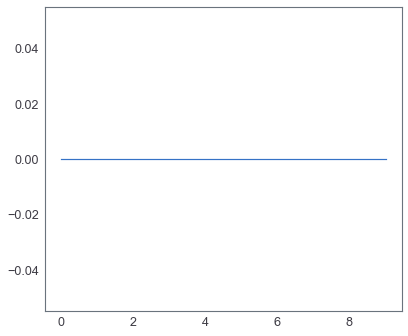

In [7]:
parameters = {'n_estimators':[25, 50, 100], 'max_depth':[4, 10, 15]}
# SVM = svm.SVC(probability=True) #recall, we need to set probability to True if we want to use predict_proba function that we need to do key rank
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=3, n_jobs=-1, scoring='accuracy') #we conduct hyperparameter tuning and cross-validation
clf.fit(tracesTrain_sel, outputSbox[0:trainSize]) # train the model
print(clf.best_estimator_) #optional: if you want to check what is the best model (if you would be using different ones)
print(clf.best_params_) #optional: if you want to check what are the best hyperparameters from the tested ones
print(clf.best_score_) #optional: if you want to check what is the accuracy on training set
# Y_pred_svm = clf.predict_proba(tracesTest_sel) #model validation
Y_pred_rf = clf.predict_proba(tracesTest_sel) #model validation

#next, we evaluate the key rank: how many attack traces we need before guessing the correct key
key_rank = []
pred = np.zeros(256)
results = np.zeros(10)
for i in range(len(tracesTest_sel)): #we evaluate on test traces
    for keyGuess in range(256): #for every possible key guess
        value = sbox[ptTest[i][0] ^ keyGuess] #calculate the output of the S-box for that specific attack trace
#         pred[keyGuess] += np.log(Y_pred_svm[i][value]+ 1e-36) #sum the probabilities
        pred[keyGuess] += np.log(Y_pred_rf[i][value]+ 1e-36) #sum the probabilities

    # Calculate key rank
    print (pred.argsort()[-5:])#to see 15 best guesses    
    res = np.argmax(np.argsort(pred)[::-1] == knownkey[0][0]) #to see on what position is the correct guess
    print(res)
    results[i] = res

#plot the results
plt.plot(results)
plt.grid()
plt.show()

### Hamming weight leakage models

In [8]:
#Pre-process step: all features are set into [0,1]. For training set, we fit and transform, while for test set, we only transform
scaler = preprocessing.MinMaxScaler()
tracesTrain_trans = scaler.fit_transform(tracesTrain)
tracesTest_trans  = scaler.transform(tracesTest)

#Feature engineering step: we use chi2 feature selection and take 50 best features. For training set, we fit and transform, while for test set, we only transform
fs = SelectKBest(score_func=chi2, k=50)
fs.fit(tracesTrain_trans, outputSboxHW[0:trainSize])
tracesTrain_sel = fs.transform(tracesTrain_trans)
tracesTest_sel = fs.transform(tracesTest_trans)

RandomForestClassifier(max_depth=20, n_estimators=150)
{'max_depth': 20, 'n_estimators': 150}
0.7672008215403738
[ 67 156 229 234  66]
10
[ 69 118 117 147 219]
7
[148  43   7 194 147]
3
[148 147 201 118  43]
0
[159 201 147 118  43]
0
[ 34  37  47 118  43]
0
[  6  34  37 118  43]
0
[119  68  37 118  43]
0
[119  68  37 118  43]
0
[ 22 183  37 118  43]
0


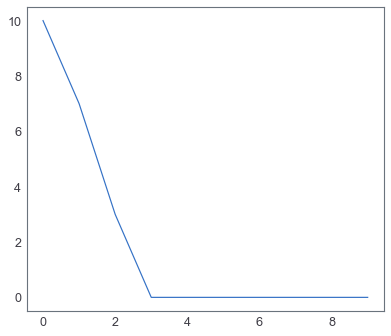

In [9]:
parameters = {'n_estimators':[100, 150, 200], 'max_depth':[5, 10, 20]}
# SVM = svm.SVC(probability=True) #recall, we need to set probability to True if we want to use predict_proba function that we need to do key rank
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=3, n_jobs=-1, scoring='accuracy') #we conduct hyperparameter tuning and cross-validation
clf.fit(tracesTrain_sel, outputSboxHW[0:trainSize]) # train the model
print(clf.best_estimator_) #optional: if you want to check what is the best model (if you would be using different ones)
print(clf.best_params_) #optional: if you want to check what are the best hyperparameters from the tested ones
print(clf.best_score_) #optional: if you want to check what is the accuracy on training set
# Y_pred_svm = clf.predict_proba(tracesTest_sel) #model validation
Y_pred_rf = clf.predict_proba(tracesTest_sel) #model validation

#next, we evaluate the key rank: how many attack traces we need before guessing the correct key
key_rank = []
pred = np.zeros(256)
results = np.zeros(10)
for i in range(len(tracesTest_sel)): #we evaluate on test traces
    for keyGuess in range(256): #for every possible key guess
        value = hamming[sbox[ptTest[i][0] ^ keyGuess]] #calculate the output of the S-box for that specific attack trace
#         pred[keyGuess] += np.log(Y_pred_svm[i][value]+ 1e-36) #sum the probabilities
        pred[keyGuess] += np.log(Y_pred_rf[i][value]+ 1e-36) #sum the probabilities

    # Calculate key rank
    print (pred.argsort()[-5:])#to see 15 best guesses    
    res = np.argmax(np.argsort(pred)[::-1] == knownkey[0][0]) #to see on what position is the correct guess
    print(res)
    results[i] = res

#plot the results
plt.plot(results)
plt.grid()
plt.show()

# Machine Learning for Side Channel Attack for Whole Key

## Model Training & Validation

In [10]:
all_traces = np.load('./chipwhisperer/traces.npy')[:-1] 
pt = np.load('./chipwhisperer/plain.npy')
knownkey = np.load('./chipwhisperer/key.npy')
traces = all_traces.copy()

def MLSCA_rf(key=[0], trainSize=5000, testSize=10, numFeatures=50, leakage_model='intermediate'):
    '''
    key: the index of subkey
    trainSize: the number of traces for training, starting from 0
    testSize: the number of traces for testing, starting from 9000
    leakage_model: 'intermediate' or 'hamming'
    --------------------------------------------------------------
    return the best key and the gussing entropy for each round
    ______________________________________________________________
    '''
    tracesTrain = traces[0:trainSize]
    ptTrain  = pt[0:trainSize]
    tracesTest = traces[9000:9000+testSize]
    ptTest  = pt[9000:9000+testSize]

    GE = []
    best_key = []
    for subkey in tqdm(key):
        outputSbox = [sbox[ptTrain[i][subkey] ^ knownkey[i][subkey]] for i in range(trainSize)]
        outputSboxHW = [hamming[s] for s in outputSbox]

        scaler = preprocessing.MinMaxScaler()
        tracesTrain_trans = scaler.fit_transform(tracesTrain)
        tracesTest_trans  = scaler.transform(tracesTest)
        fs = SelectKBest(score_func=chi2, k=numFeatures)
        if(leakage_model=='hamming'):
            fs.fit(tracesTrain_trans, outputSboxHW[0:trainSize])
        elif(leakage_model=='intermediate'):
            fs.fit(tracesTrain_trans, outputSbox[0:trainSize])
        tracesTrain_sel = fs.transform(tracesTrain_trans)
        tracesTest_sel = fs.transform(tracesTest_trans)

        parameters = {'n_estimators':[50, 100, 150], 'max_depth':[5, 10, 20]}
        rf = RandomForestClassifier()
        clf = GridSearchCV(rf, parameters, cv=3, n_jobs=-1, scoring='accuracy')
        if(leakage_model=='hamming'):
            clf.fit(tracesTrain_sel, outputSboxHW[0:trainSize])
        elif(leakage_model=='intermediate'):
            clf.fit(tracesTrain_sel, outputSbox[0:trainSize])
        Y_pred_rf = clf.predict_proba(tracesTest_sel)

        best_subkey = []
        pred = np.zeros(256)
        results = np.zeros(testSize)
        for i in range(testSize):
            for keyGuess in range(256):
                if(leakage_model=='hamming'):
                    value = hamming[sbox[ptTest[i][subkey] ^ keyGuess]]
                elif(leakage_model=='intermediate'):
                    value = sbox[ptTest[i][subkey] ^ keyGuess]
                else:
                    print('Error: undefined leakage model')
                pred[keyGuess] += np.log(Y_pred_rf[i][value]+ 1e-36)

            best_subkey.append(pred.argsort()[-1])
            res = np.argmax(np.argsort(pred)[::-1] == knownkey[0][subkey])
            results[i] = res
    
        best_key.append(best_subkey)
        GE.append(results)

    return best_key, GE

In [11]:
best_key_hamming, GE_hamming = MLSCA_rf(key=np.arange(0,16), trainSize=5000, numFeatures=50, leakage_model='hamming')
best_key_inter, GE_inter = MLSCA_rf(key=np.arange(0,16), trainSize=5000, numFeatures=50, leakage_model='intermediate')

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [03:42<00:00, 13.89s/it]


## Result Visualization 

In [12]:
def geVisual(best_key, GE):
    plt.figure(figsize=(36,25))
    xx = np.arange(0,len(GE[0])) + 1
    for k in range(16):
        plt.subplot(4,4,k+1)
        plt.plot(xx, GE[k], '-*')
        plt.xlabel("number of testing traces")
        plt.ylabel('gussing entropy')
        plt.title('subkey[%d]'%k)
        plt.xticks(xx)
        numTraces = -1
        for xy in zip(xx, GE[k]):
            numTraces += 1
            plt.annotate(best_key[k][numTraces], xy=xy, 
                         xytext=(1, 3), textcoords='offset points')

### Hamming Weight Leakage Model

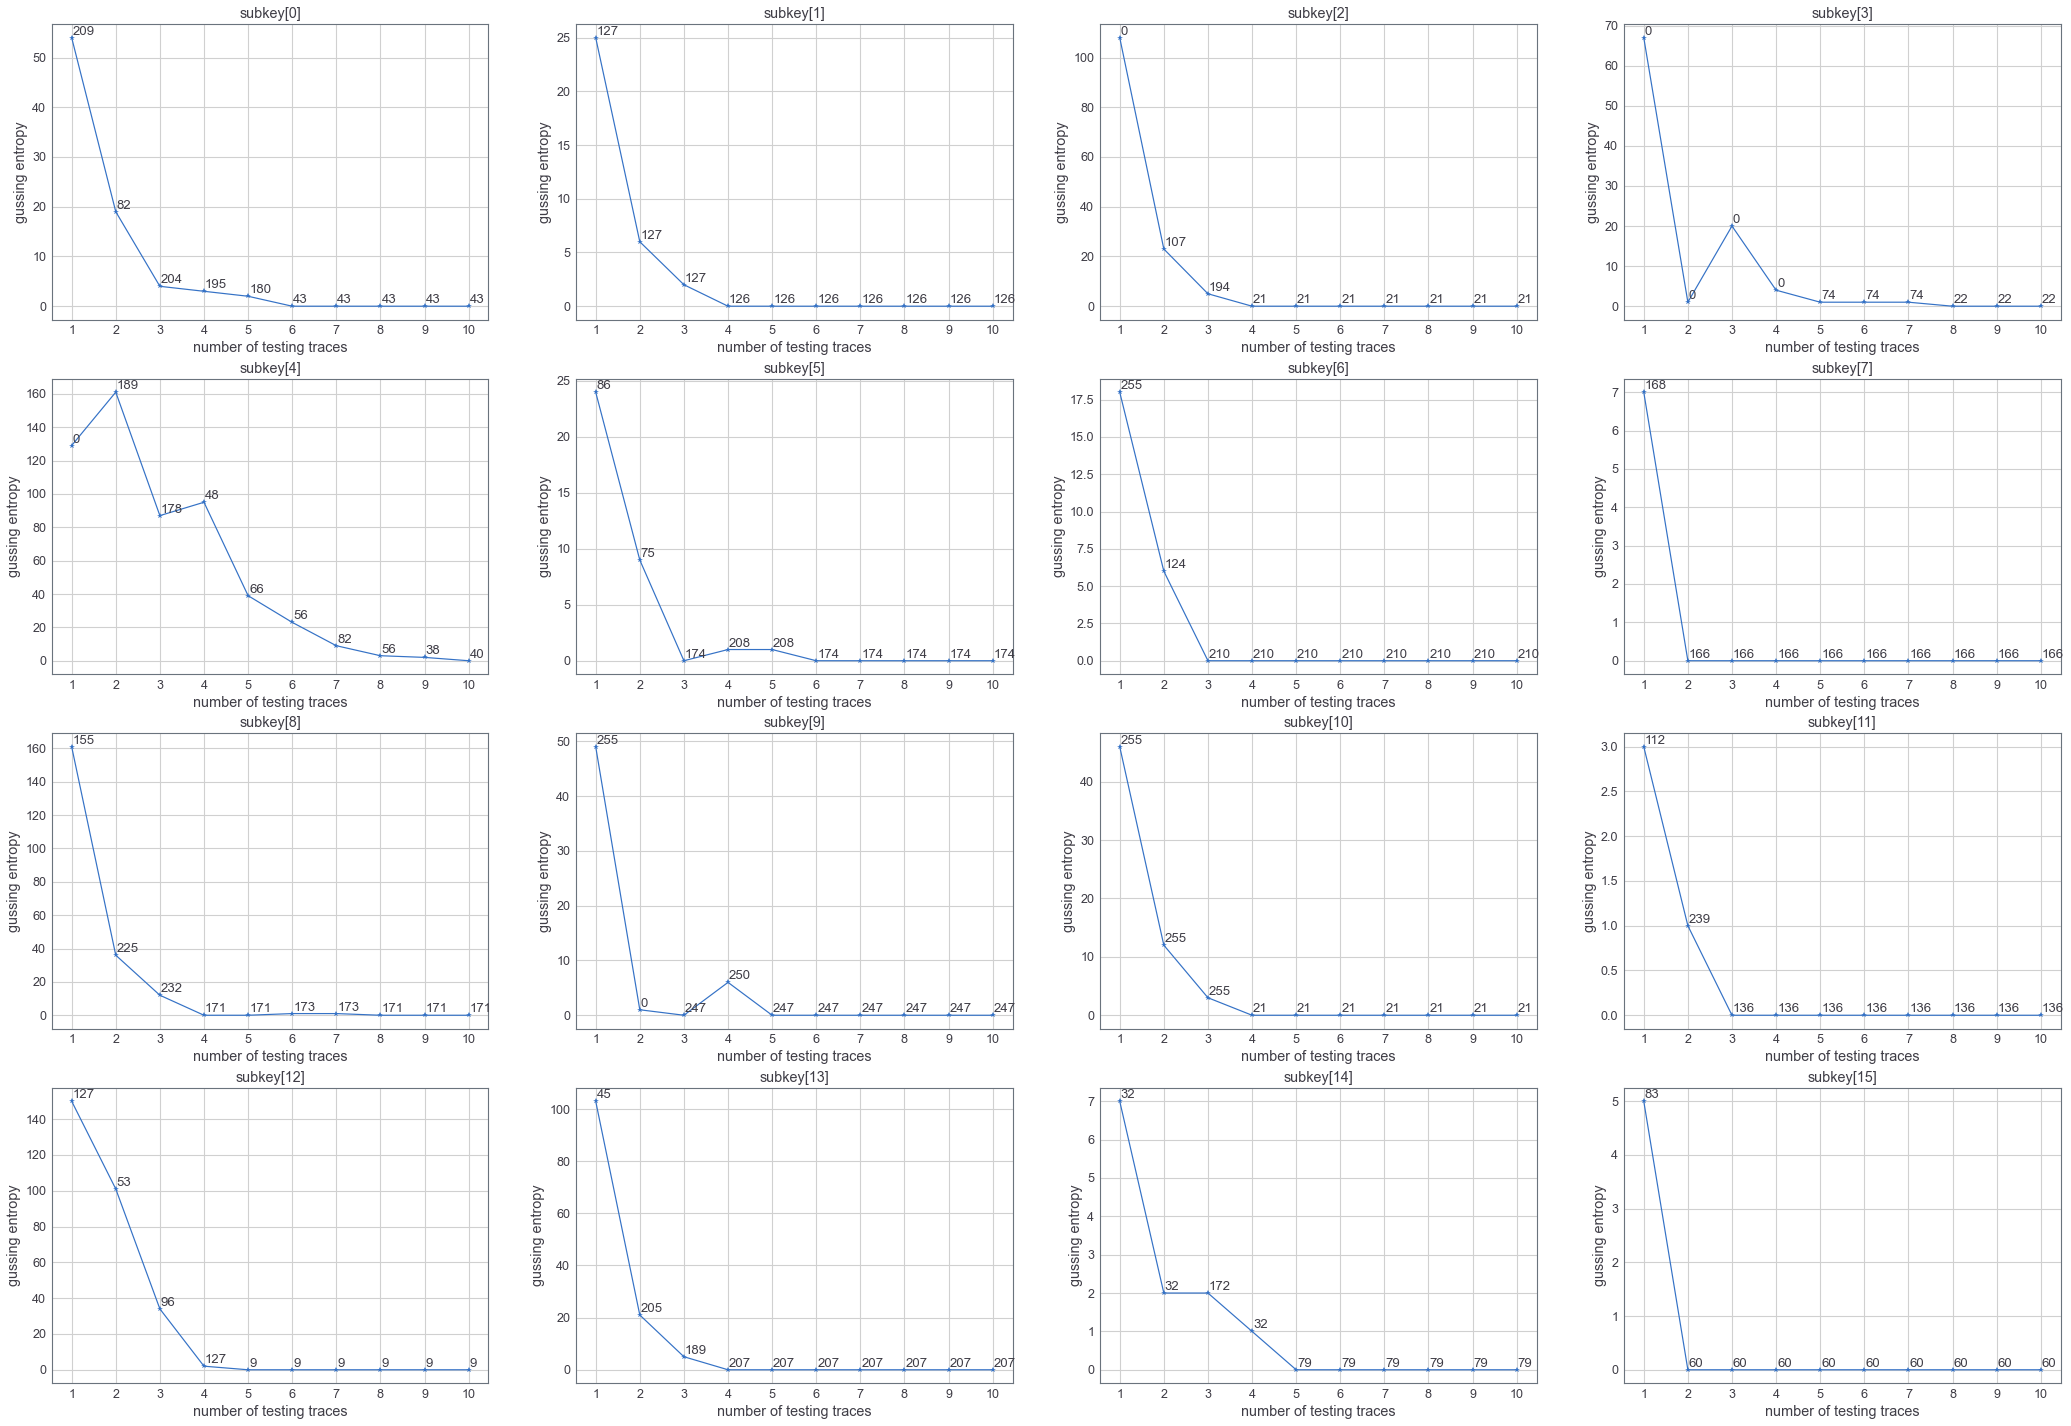

In [13]:
geVisual(best_key_hamming, GE_hamming)
# plt.savefig('./figures/MLSCA/hamming_leakage_model.pdf', dpi=1200)

### Intermediate Leakage Model

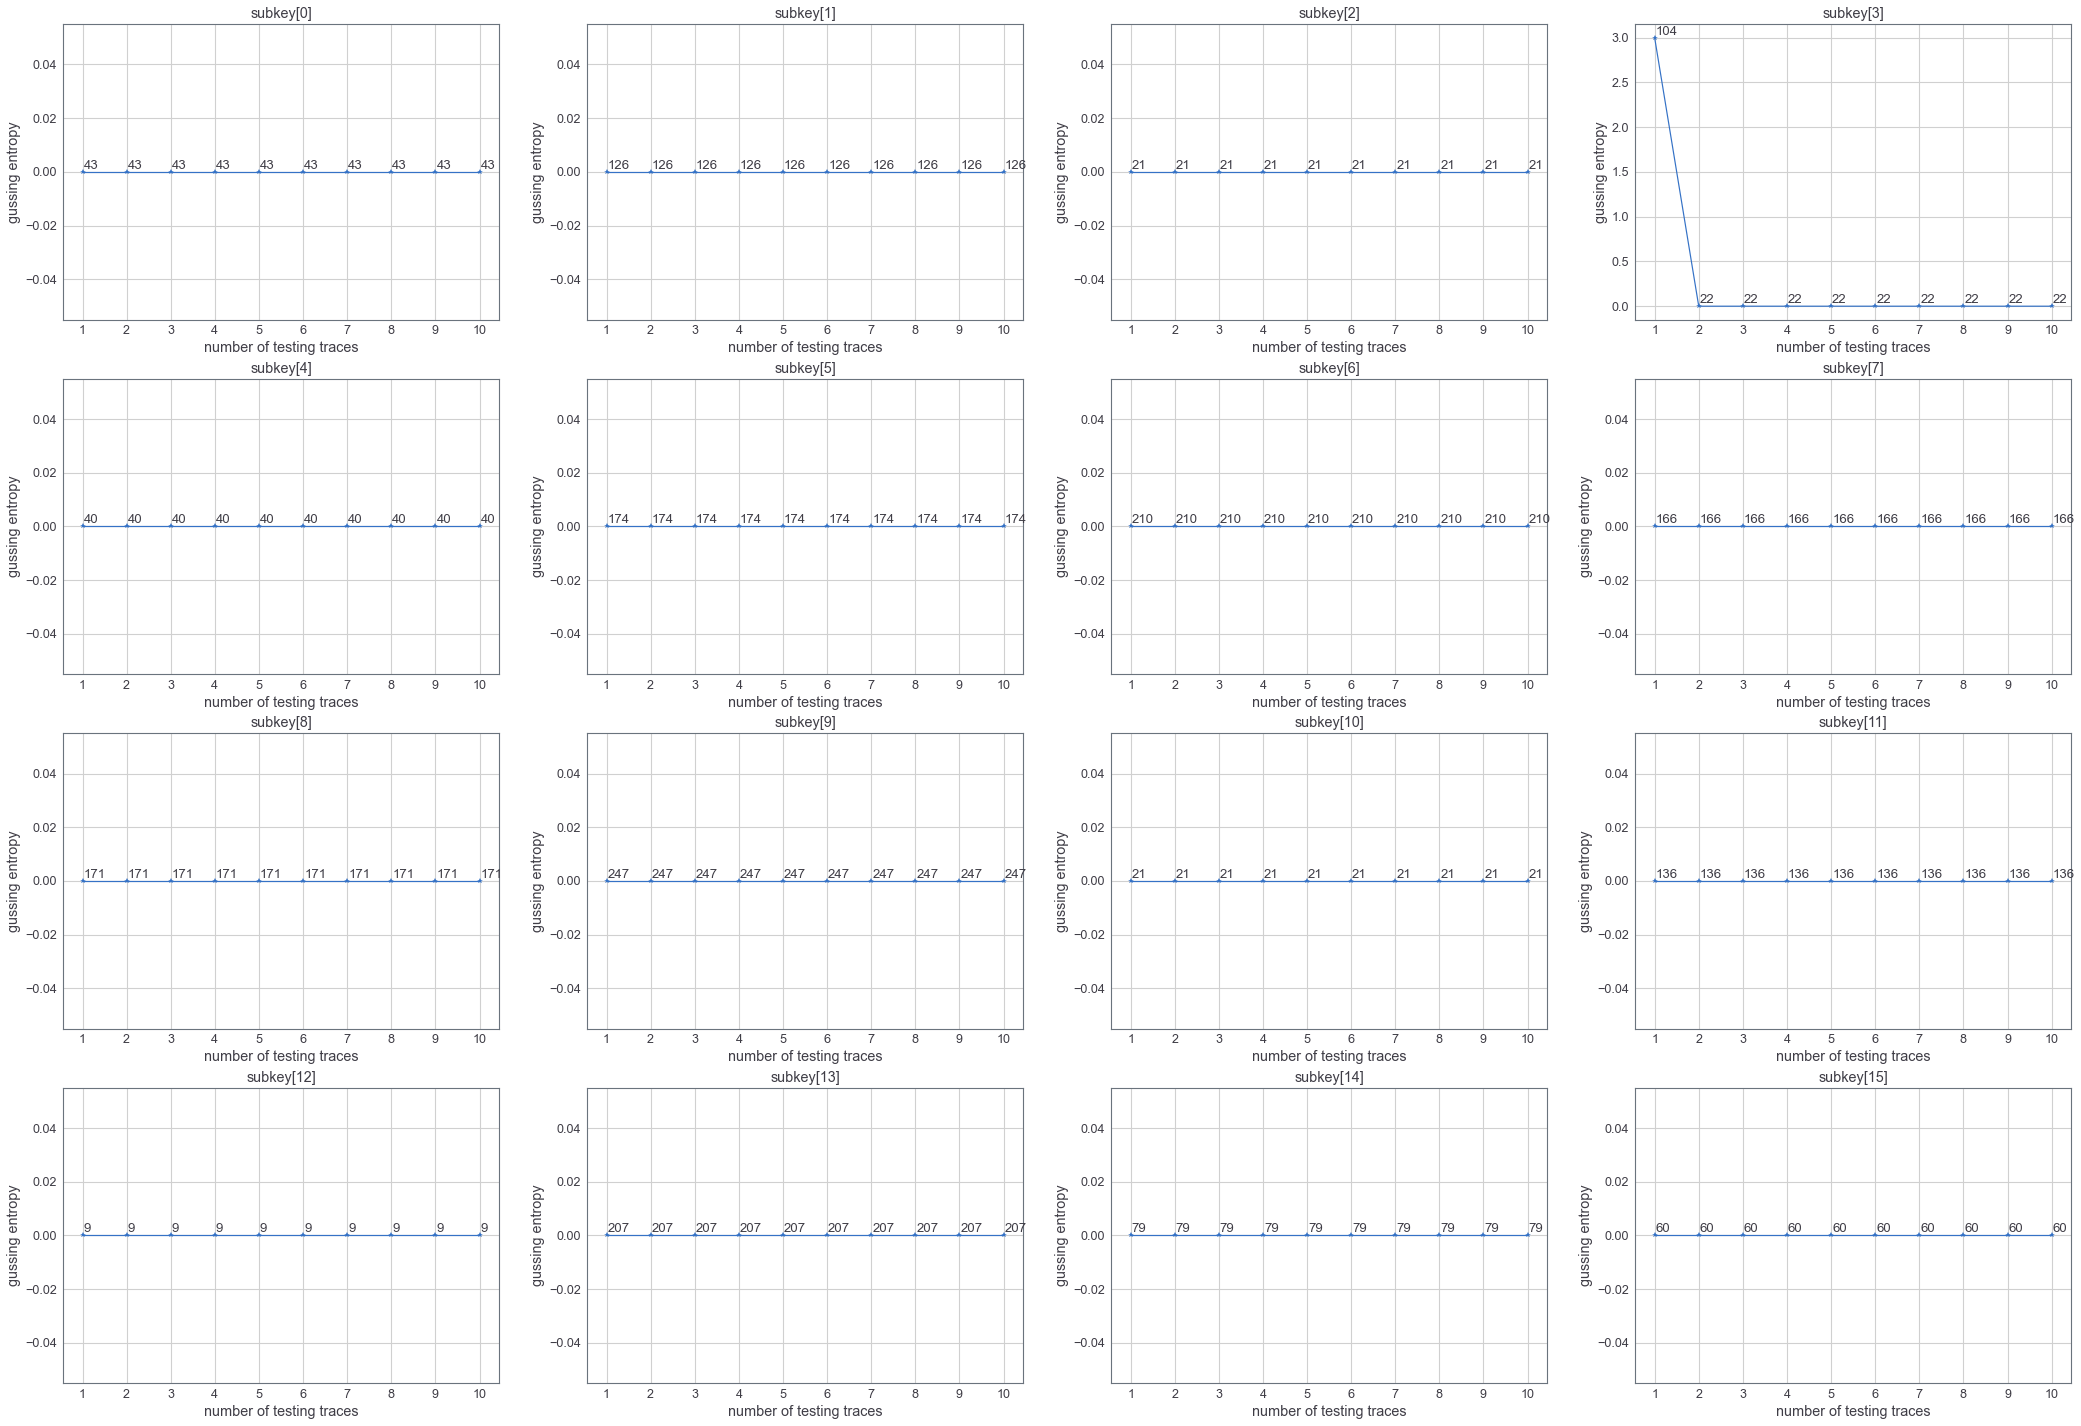

In [14]:
geVisual(best_key_inter, GE_inter)
# plt.savefig('./figures/MLSCA/intermediate_leakage_model.pdf', dpi=1200)

# Desynchronization

## Add Desynchronization

In [15]:
def add_desync(traces, desync_level):
    desync_traces = np.zeros(traces.shape)
    for t in range(len(traces)):
        level = np.random.randint(0, desync_level)
        for i in range(len(traces[t]) - level):
            desync_traces[t,i] = traces[t,i+level]
    return desync_traces

In [16]:
traces = add_desync(all_traces, 10)

## Model Training & Validation

In [17]:
best_key_hamming, GE_hamming = MLSCA_rf(key=np.arange(0,16), trainSize=5000, numFeatures=50, leakage_model='hamming')
best_key_inter, GE_inter = MLSCA_rf(key=np.arange(0,16), trainSize=5000, numFeatures=50, leakage_model='intermediate')

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [02:14<00:00,  8.39s/it]


## Result Visualization

### Hamming Weight Leakage Model

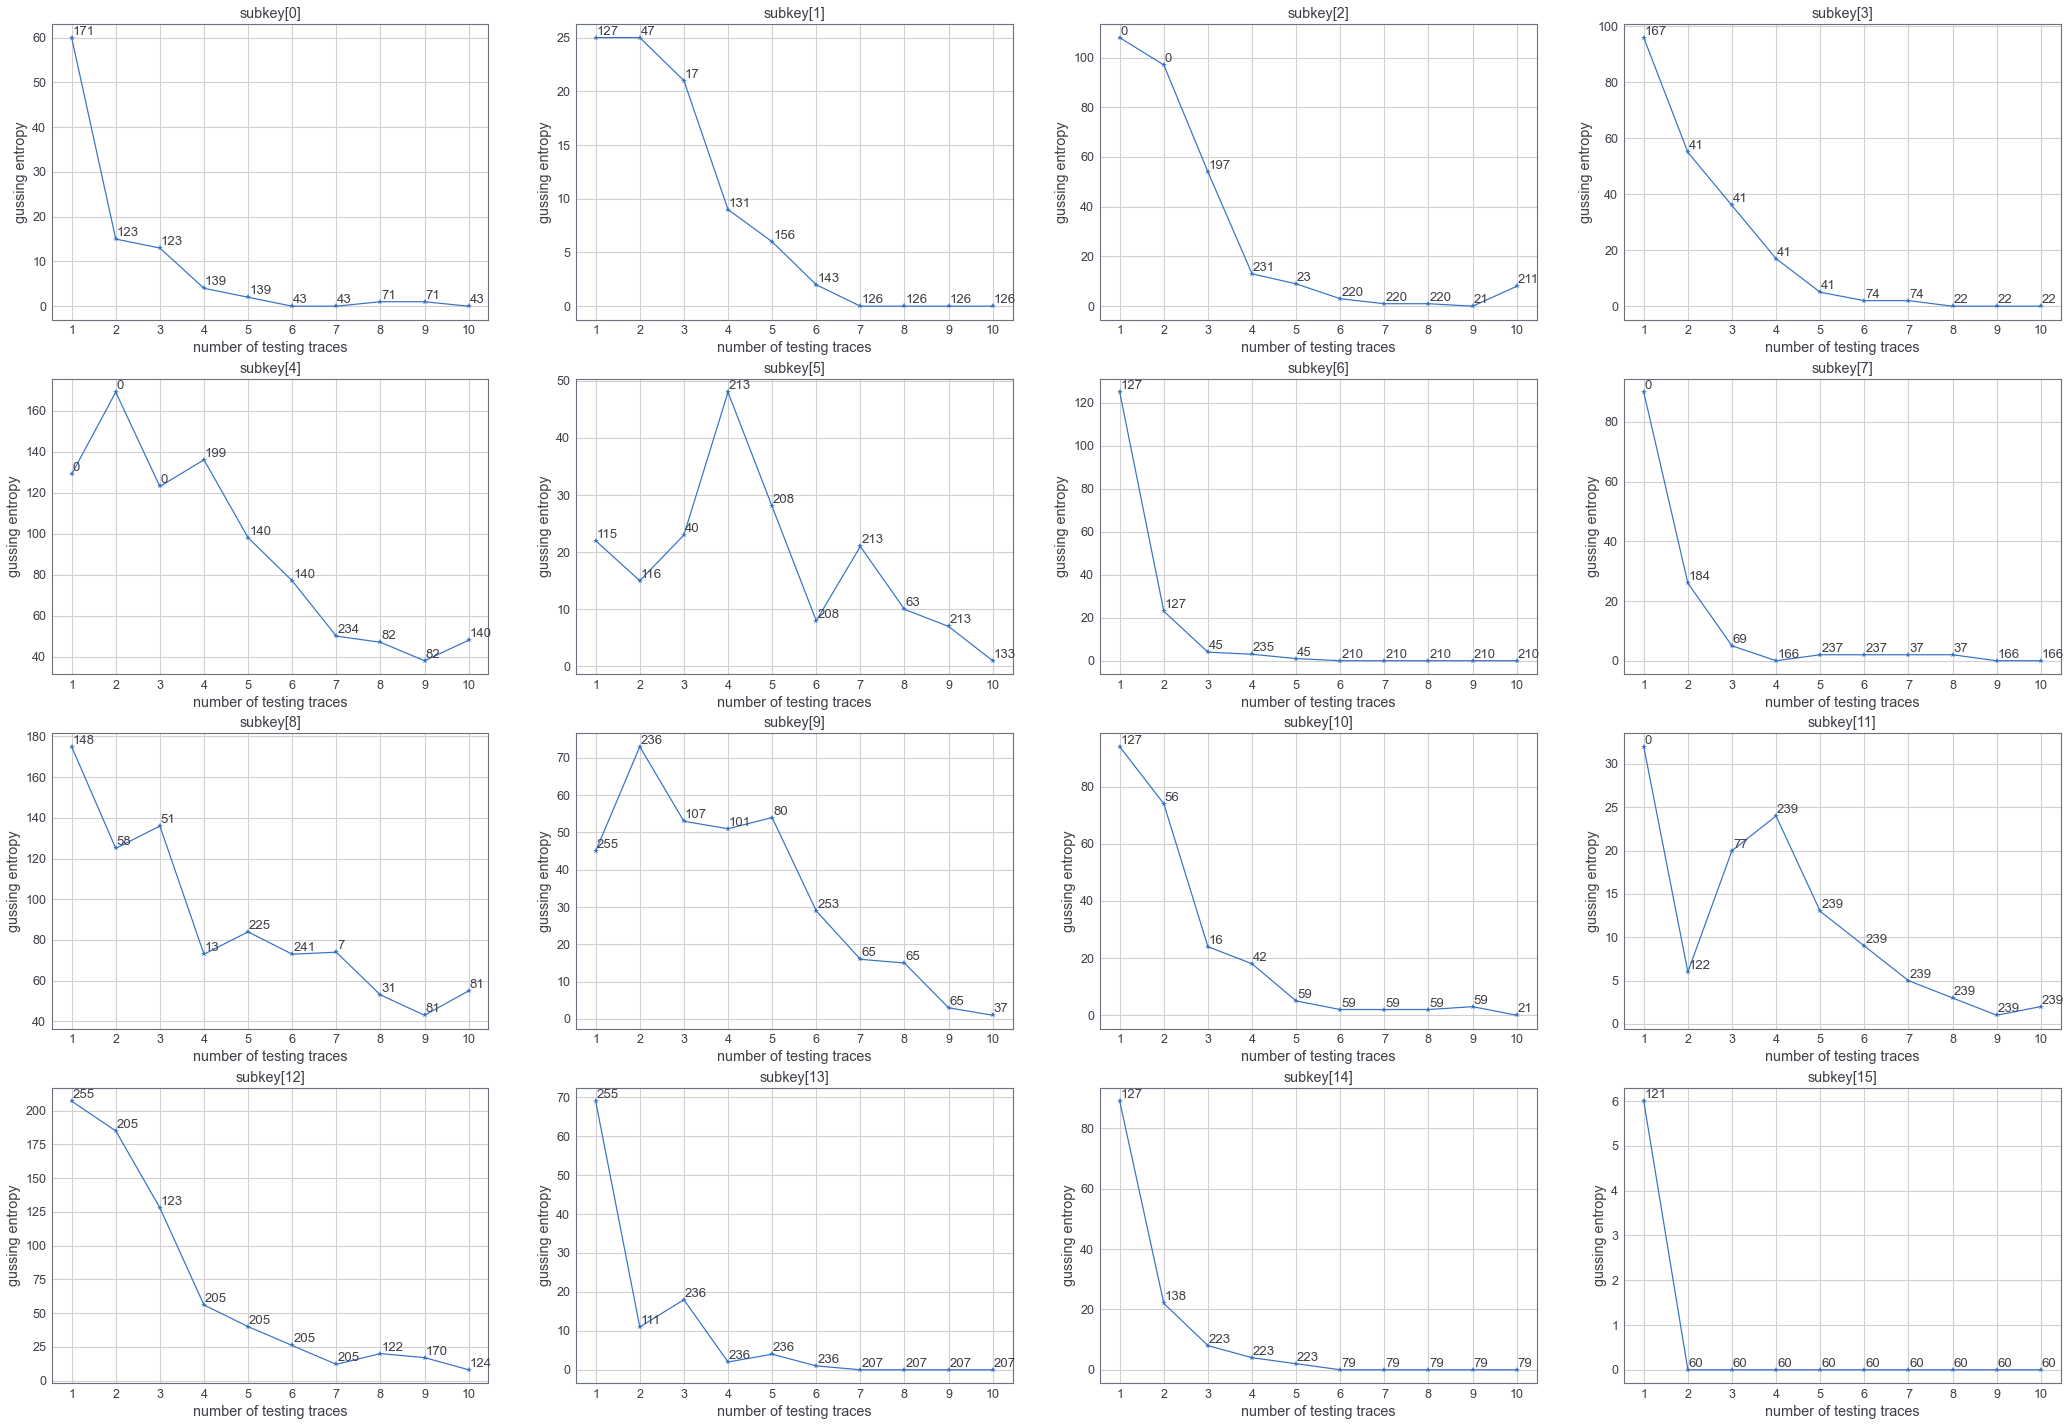

In [22]:
geVisual(best_key_hamming, GE_hamming)
# plt.savefig('./figures/MLSCA/hamming_leakage_model_desync.pdf', dpi=1200)

### Intermediate Leakage Model

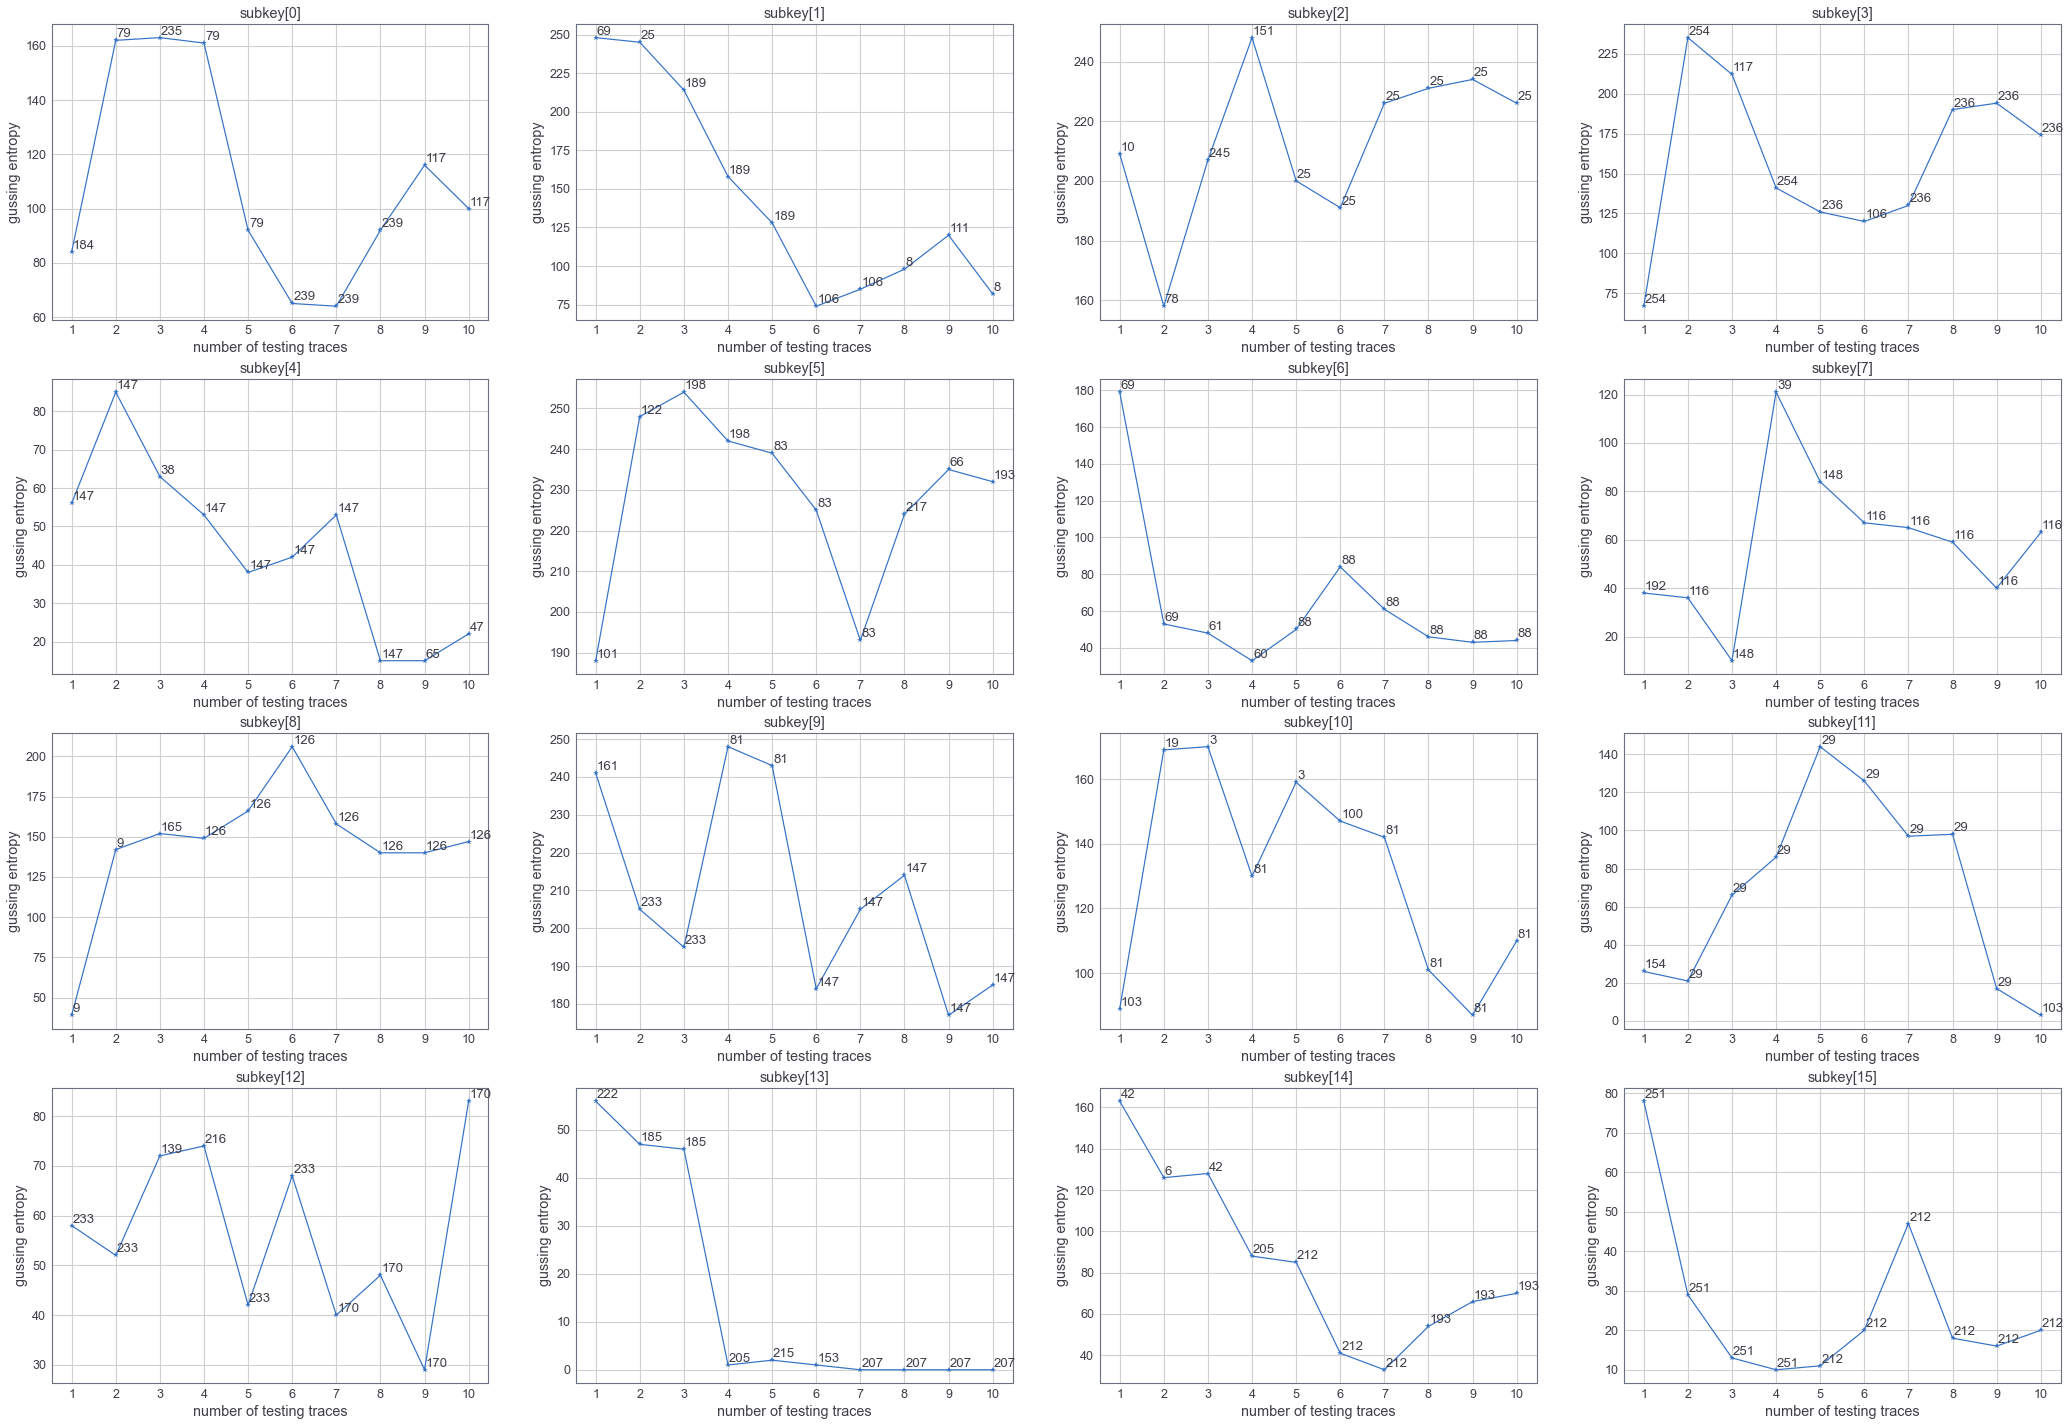

In [23]:
geVisual(best_key_inter, GE_inter)
# plt.savefig('./figures/MLSCA/intermediate_leakage_model_desync.pdf', dpi=1200)